In [1]:
import numpy as np
import math
from fractions import Fraction
import itertools
from biotuner_utils import *
from biotuner_offline import *
from biotuner import *
from biotuner_object import *
from biotuner2d import *
import matplotlib.pyplot as plt
from numpy import array, zeros, ones, arange, log2, sqrt, diff, concatenate
import emd
from PyEMD import EMD, EEMD
from scipy.signal import butter, lfilter
import colorednoise as cn

import mne
import os
import time


pygame 2.0.1 (SDL 2.0.14, Python 3.7.4)
Hello from the pygame community. https://www.pygame.org/contribute.html


#### This notebook is intended to demonstrate the use of the biotuner (https://github.com/antoineBellemare/biotuner/)
#### The general idea is extract harmonic information from biological time series to inform the computation of musical structures
#### The terms ''tuning'' and ''scale'' will be used interchangeably, referring to a series of ratios that subdivide an octave

## Load dataset

In [2]:

#path = 'D:/Science/EEG_data/'
path = 'C:/Users/Dell/GitHub/CoCoBrainChannel/'
epochs = mne.read_epochs(path+'pareidolia_run2.fif')
epochs = epochs.apply_baseline((-1.5, -0.1))
#epochs = epochs.crop(0.5, 7.5)
epochs_data = epochs.get_data()

Reading C:/Users/Dell/GitHub/CoCoBrainChannel/pareidolia_run2.fif ...


<ipython-input-2-4c36a6ad8073>:3: RuntimeWarning: This filename (C:/Users/Dell/GitHub/CoCoBrainChannel/pareidolia_run2.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs = mne.read_epochs(path+'pareidolia_run2.fif')


    Found the data of interest:
        t =   -1500.00 ...    8000.00 ms
        0 CTF compensation matrices available


C:\Users\Dell\Anaconda3\lib\site-packages\mne\io\tag.py:427: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  ch_name = ch_name[:np.argmax(ch_name == b'')].tostring()
C:\Users\Dell\Anaconda3\lib\site-packages\mne\io\tag.py:427: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  ch_name = ch_name[:np.argmax(ch_name == b'')].tostring()
C:\Users\Dell\Anaconda3\lib\site-packages\mne\io\tag.py:427: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  ch_name = ch_name[:np.argmax(ch_name == b'')].tostring()
C:\Users\Dell\Anaconda3\lib\site-packages\mne\io\tag.py:427: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  ch_name = ch_name[:np.argmax(ch_name == b'')].tostring()
C:\Users\Dell\Anaconda3\lib\site-packages\mne\io\tag.py:427: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  ch_name = ch_name[:np.argmax(ch_name == b'')].tostring()
C:\Users\Dell\Anaconda3\lib\site-packages\mne\io\tag.py

104 matching events found
Applying baseline correction (mode: mean)
Not setting metadata
0 projection items activated
Applying baseline correction (mode: mean)


## peaks_extraction and peaks_extension methods

There is no minimum size for time series. However, time series shorter than 1 second will not allow for peak extraction below 2Hz.

Peaks functions:

'fixed' : ranges of frequency bands are fixed

'adapt' : ranges of frequency bands are defined based on the alpha peak

'EMD': Intrinsic Mode Functions (IMFs) are derived from Empirical Mode Decomposition (EMD)  
                   FFT is computed on each IMF
                   
'EEMD': Intrinsic Mode Functions (IMFs) are derived from Ensemble Empirical Mode Decomposition (EMD)  
                    FFT is computed on each IMF
                    
'HH1D_max': maximum values of the 1d Hilbert-Huang transform on each IMF using EEMD.

'harmonic_peaks': keeps peaks for which a maximum of other peaks are harmonics

'cepstrum': peak frequencies of the cepstrum (inverse Fourier transform (IFT) of the logarithm of the estimated signal spectrum)

'FOOOF' : peaks rising above the aperiodic component

In [3]:

start = time.time()
FREQ_BANDS = [[1, 3], [3, 7], [7, 12], [12, 18], [18, 30], [30, 45]] # Define frequency bands for peaks_function = 'fixed'
data = epochs_data[7][35][3000:5000] # Define data (single time series)


biotuning = biotuner(sf = 1000, peaks_function = 'EEMD', precision = 0.1, n_harm = 10,
                    ratios_n_harms = 5, ratios_inc_fit = True, ratios_inc = True) # Initialize biotuner object

biotuning.peaks_extraction(data, FREQ_BANDS = FREQ_BANDS, ratios_extension = True, max_freq = 50)
biotuning.compute_peaks_metrics()

stop = time.time()
print(stop-start)

0.04260563850402832


C:\Users\Dell\Anaconda3\lib\site-packages\scipy\signal\spectral.py:1966: UserWarning: nperseg = 10000 is greater than input length  = 2000, using nperseg = 2000
  .format(nperseg, input_length))
C:\Users\Dell\GitHub\biotuner\biotuner.py:157: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  harm_fit = np.array(harm_temp).squeeze()


In [4]:
print('Peaks:', biotuning.peaks)
print('Peaks consonance metrics:', biotuning.peaks_metrics)

Peaks: [ 1.2  1.8  7.4  7.6 19.3]
Peaks consonance metrics: {'cons': 0.11302430065479308, 'euler': 253, 'tenney': 9.404897667257403, 'harm_fit': 22, 'harmsim': 11.025164788459032}


## Dissonance curve

The dissonance curve needs as input a list of peaks and a list of associated amplitudes. Since providing less than 6 spectral peaks would lead to less interesting dissonance curve, the method ''peaks_extension'' provides a way to extend the number of peaks based on the harmonic_fit function (see biotuner.py)

peaks_extension methods: 
['harmonic_fit', 'consonant', 'multi_consonant', 'consonant_harmonic_fit', 'multi_consonant_harmonic_fit']

[1400, 1500, 1710, 2000]


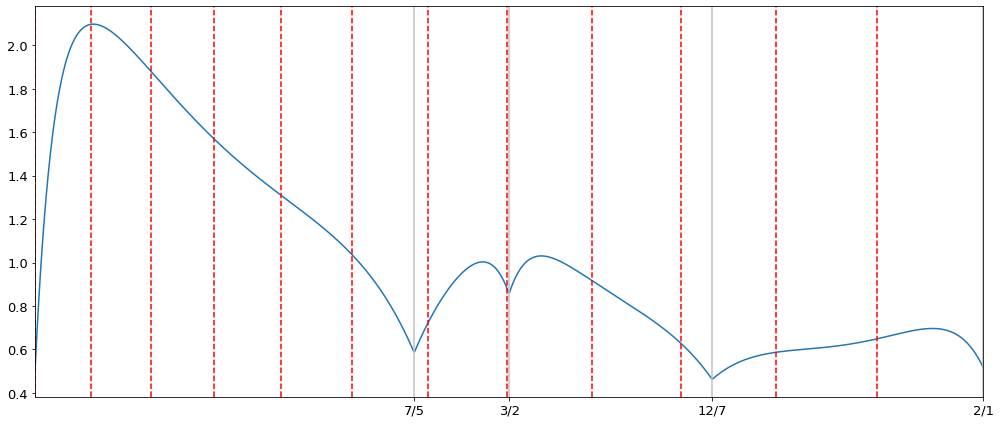

intervals [(7, 5), (3, 2), (12, 7), (2, 1)]


In [5]:
biotuning.peaks_extension(method = 'consonant_harmonic_fit', harm_function = 'mult',  n_harm = 2, cons_limit = 0.1, 
                          ratios_extension = True, scale_cons_limit = 0.1)
biotuning.compute_diss_curve(plot = True, input_type = 'extended_peaks', euler_comp = False, denom = 100, max_ratio = 2, n_tet_grid = 12)


In [6]:
print('Dissonance curve metrics:', biotuning.scale_metrics)
print('Dissonance curve tuning:', biotuning.diss_scale)
print('Dissonance curve consonant tuning:', biotuning.diss_scale_cons)

Dissonance curve metrics: {'diss_euler': 'NaN', 'dissonance': 1.027787301252536, 'diss_harm_sim': 39.84126984126984, 'diss_n_steps': 4}
Dissonance curve tuning: [1.4, 1.5, 1.7142857142857142, 2.0]
Dissonance curve consonant tuning: [1.4   1.5   1.714 2.   ]


In [7]:
### If you want the tuning in fraction
scale_frac, num, denom = scale2frac (biotuning.diss_scale, maxdenom = 1000)
scale_frac

[Fraction(7, 5), Fraction(3, 2), Fraction(12, 7), Fraction(2, 1)]

## Harmonic entropy

Harmonic entropy takes as input a list of ratios.

If input_type = 'peaks' or 'extended_peaks', their ratios will be used.
Other input types use extended ratios : see biotuner ref.

'extended_ratios_inc'  (increments of the ratios in the form of 'r^1, r^2, r^3, ... r^n)

'extended_ratios_inc_fit' (harmonic fit between the ratios increments)

'extended_ratios_harm'


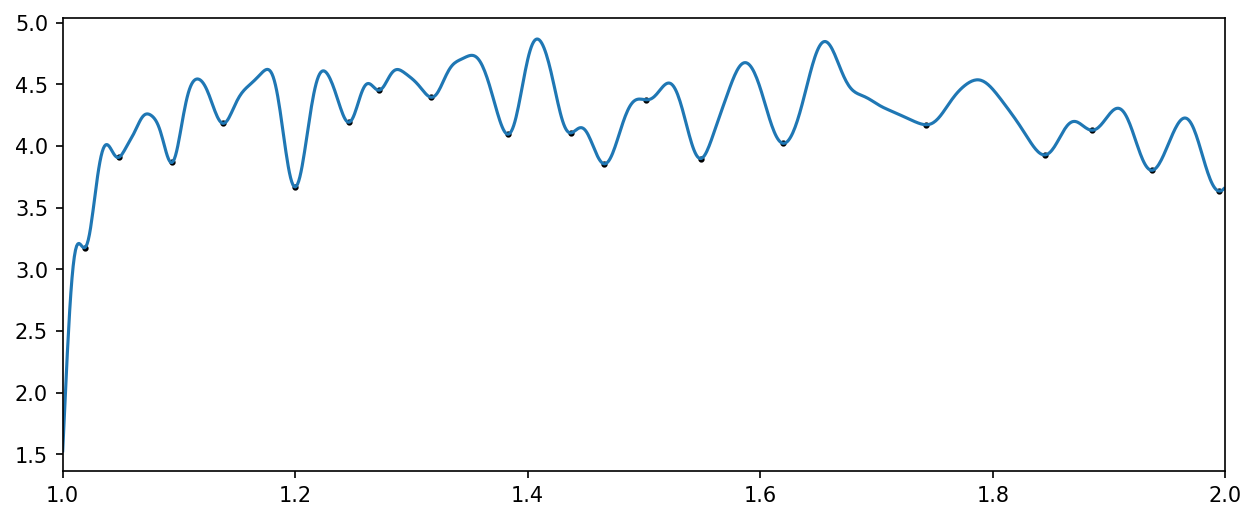

In [8]:
biotuning.peaks_extension(method = 'consonant_harmonic_fit', harm_function = 'mult',  n_harm = 20, 
                          cons_limit = 0.1, ratios_extension = True)
biotuning.compute_harmonic_entropy(input_type = 'extended_ratios_inc', plot_entropy = True, octave = 2, rebound = False, 
                                   scale_cons_limit = 0.01, sub=False)

In [9]:
print('Harmonic entropy metrics:', biotuning.scale_metrics)
print('Harmonic entropy tuning:', biotuning.HE_scale)
print('Harmonic entropy consonant tuning:', biotuning.HE_scale_cons)

Harmonic entropy metrics: {'diss_euler': 'NaN', 'dissonance': 1.027787301252536, 'diss_harm_sim': 39.84126984126984, 'diss_n_steps': 4, 'HE': 4.249283522549746, 'HE_n_steps': 19, 'HE_harm_sim': 2.357021919634874}
Harmonic entropy tuning: [1.019 1.048 1.094 1.138 1.2   1.246 1.272 1.317 1.383 1.437 1.466 1.502
 1.549 1.62  1.743 1.845 1.885 1.937 1.995]
Harmonic entropy consonant tuning: [1.048 1.2   1.272 1.62 ]


In [10]:
### If you want the tuning in fraction
scale_frac, num, denom = scale2frac (biotuning.HE_scale, maxdenom = 100)
scale_frac

[Fraction(54, 53),
 Fraction(87, 83),
 Fraction(93, 85),
 Fraction(33, 29),
 Fraction(6, 5),
 Fraction(76, 61),
 Fraction(117, 92),
 Fraction(54, 41),
 Fraction(65, 47),
 Fraction(125, 87),
 Fraction(129, 88),
 Fraction(3, 2),
 Fraction(79, 51),
 Fraction(81, 50),
 Fraction(61, 35),
 Fraction(131, 71),
 Fraction(164, 87),
 Fraction(184, 95),
 Fraction(199, 100)]

##  Deriving tunings from peaks ratios

In [11]:
biotuning.peaks_ratios  #peaks ratios

[1.0052083333333335,
 1.027027027027027,
 1.027777777777778,
 1.0555555555555556,
 1.2697368421052633,
 1.304054054054054,
 1.340277777777778,
 1.5,
 1.5416666666666667,
 1.5833333333333333]

extended peaks ratios with higher consonance levels

adjust the 'scale_cons_limit' value:
Comparisons with familiar ratios:
        #Unison-frequency ratio 1:1 yields a value of 2
        Octave-frequency ratio 2:1 yields a value of 1.5
        Perfect 5th-frequency ratio 3:2 yields a value of 0.833
        Perfect 4th-frequency ratio 4:3 yields a value of 0.583
        Major 6th-frequency ratio 5:3 yields a value of 0.533
        Major 3rd-frequency ratio 5:4 yields a value of 0.45
        Minor 3rd-frequency ratio 5:6 yields a value of 0.366
        Minor 6th-frequency ratio 5:8 yields a value of 0.325
        Major 2nd-frequency ratio 8:9 yields a value of 0.236
        Major 7th-frequency ratio 8:15 yields a value of 0.192
        Minor 7th-frequency ratio 9:16 yields a value of 0.174
        Minor 2nd-frequency ratio 15:16 yields a value of 0.129

In [12]:
biotuning.peaks_extension(method = 'consonant_harmonic_fit', harm_function = 'mult',  n_harm = 20, 
                          cons_limit = 0.1, ratios_extension = True, scale_cons_limit = 0.235) 
biotuning.extended_peaks_ratios_cons

array([1.125, 1.167, 1.2  , 1.25 , 1.286, 1.333, 1.4  , 1.5  , 1.667,
       1.75 , 1.8  , 1.833, 2.   ])

## Exporting scale in scala format

In [13]:
create_SCL(biotuning.HE_scale, 'Harmonic_entropy_scale')
create_SCL(biotuning.diss_scale, 'Dissonance_curve_scale')
create_SCL(biotuning.peaks_ratios, 'Peaks_ratios_scale')
create_SCL(biotuning.extended_peaks_ratios_cons, 'consonant_extended_peaks_ratios_scale')


## Computing scale metrics 

#### From peaks ratios

In [14]:
metrics_peaks, _ = scale_to_metrics(biotuning.peaks_ratios)
metrics_peaks

{'sum_p_q': 1690,
 'sum_distinct_intervals': 99,
 'metric_3': 298.495421032703,
 'sum_p_q_for_all_intervals': 198255,
 'sum_q_for_all_intervals': 90780,
 'harm_sim': 11.24}

#### From dissonance curve tuning

In [15]:
metrics_peaks, _ = scale_to_metrics(biotuning.diss_scale)
metrics_peaks

{'sum_p_q': 39,
 'sum_distinct_intervals': 18,
 'metric_3': 6.90000000000000,
 'sum_p_q_for_all_intervals': 549,
 'sum_q_for_all_intervals': 235,
 'harm_sim': 54.88}

## Spectromorphological computation

NAN []
2


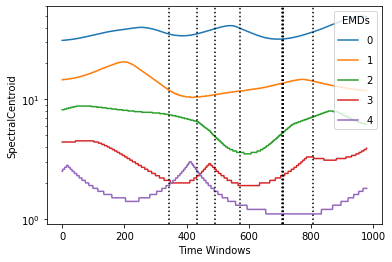

In [16]:
biotuning.compute_spectromorph(comp_chords = True, method = 'SpectralCentroid', min_notes = 4, cons_limit = 35, cons_chord_method = 'euler', 
                               window = 500, overlap = 1, graph = True)



In [17]:
biotuning.spectro_chords #correspond to moment in time when IMFs reach a level of consonance

[[36.0, 12.5, 7.5, 2.1, 1.8],
 [35.0, 10.5, 6.6, 2.2, 2.7],
 [38.4, 10.8, 5.2, 2.8, 1.8],
 [40.5, 11.7, 3.6, 2.0, 1.3],
 [32.0, 13.5, 5.0, 2.2, 1.1],
 [36.0, 14.4, 7.0, 3.3, 1.1]]

## Classical tuning creation from peaks and extended peaks

In [18]:
#Initiate object and extract peak information
biotuning_class_scales = biotuner(sf = 1000, peaks_function = 'EEMD', precision = 0.1, n_harm = 10,
                    ratios_n_harms = 5, ratios_inc_fit = True, ratios_inc = True) # Initialize biotuner object

biotuning_class_scales.peaks_extraction(data, FREQ_BANDS = FREQ_BANDS, ratios_extension = True, max_freq = 50)

#### Euler-Fokker Genera using peaks as generators (using method)

In [19]:
biotuning_class_scales.euler_fokker_scale(biotuning.peaks)

[1, 133/128, 19/16, 49/32, 7/4, 931/512, 2]

#### Euler-Fokker Genera using extended peaks as generators (using function)

In [20]:
biotuning_class_scales.peaks_extension(method = 'consonant_harmonic_fit', harm_function = 'div', div_mode = 'div_add', n_harm = 3, 
                          cons_limit = 0.6, ratios_extension = True)
euler_fokker_scale(biotuning_class_scales.extended_peaks)

NameError: name 'self' is not defined

In [ ]:
biotuning_class_scales.peaks_extension(method = 'consonant_harmonic_fit', harm_function = 'mult', div_mode = 'div_add', n_harm = 3, 
                          cons_limit = 0.6, ratios_extension = True)
biotuning_class_scales.euler_fokker_scale(biotuning.extended_peaks)

#### Harmonic scale using harmonic numbers of peaks

In [ ]:
biotuning_harm_peaks = biotuner(sf = 1000, peaks_function = 'harmonic_peaks', precision = 0.1, n_harm = 10,
                    ratios_n_harms = 5, ratios_inc_fit = True, ratios_inc = True) # Initialize biotuner object

biotuning_harm_peaks.peaks_extraction(data, FREQ_BANDS = FREQ_BANDS, ratios_extension = True, max_freq = 50)

In [ ]:
harm_tuning = harmonic_tuning(biotuning_harm_peaks.all_harmonics)
harm_tuning

In [ ]:
metrics, _ = scale_to_metrics(harm_tuning)
metrics